In [1]:
import numpy as np
from sklearn_ensemble_cv import reset_random_seeds
import matplotlib.pyplot as plt

reset_random_seeds(0)

We make up some fake data for illustration.

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=300, n_features=200,
                       n_informative=5, n_targets=1,
                       random_state=0, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# The Ensemble class

For users who want to have more control of the ensemble predictor, this section introduces lower-level class and object that we use to implement the cross-validation methods.
For users who just want to use easy interface functions, you can safely skip this section.

We provide `Ensemble` a class for ensemble predictor, whose base class is `sklearn.ensemble.BaggingRegressor`.
This means that the usage of `Ensemble` is basically the same as the latter, except the new class includes several new member functions that we will illustrate below.



## Initialize an object

The initialization of `Ensemble` class is the same as `sklearn.ensemble.BaggingRegressor`, where 

1. The base estimator object, whose hyperparameter `kwargs_regr` is specified when it is initialized. In the following example, we use decision tree as the base estimator. 
2. The hyperparameters for building an ensemble, such as `n_estimators`, `max_samples`, `max_features`, and etc.

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn_ensemble_cv import Ensemble
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr = Ensemble(estimator=DecisionTreeRegressor(**kwargs_regr), n_estimators=100, **kwargs_ensemble)

After the ensemble object `regr` is initialized, we can fit the data and get the prediction:

In [4]:
regr.fit(X_train, y_train)
regr.predict(X_test)

array([ 155.35342882,  -43.90554585,  -33.2783907 ,   48.33669145,
       -133.6810437 ,  -22.82435822,  -11.08898079,   58.2204518 ,
        -33.06845958,  -86.89981042,    3.21583217,   -7.76243828,
       -171.84887251,  -36.16022063,  109.64532578,  -38.01190759,
        173.83794179,   48.95540431,  -55.28855806,  -64.43560629,
         20.43847716,  -54.69740284,  132.26238855, -160.05236114,
       -119.21249609,  -56.68188629,   53.25840595,   14.75830822,
         26.13048957,  -45.40386277,  -61.17465006,  -12.74818443,
       -180.22829743,  102.24733668,   81.31071659,   50.6243405 ,
       -127.081336  ,  -37.04997616,  146.65264866,  147.55838428,
       -121.45236732,   -6.96984205,  -60.79025587,  -35.94497471,
       -142.22282996,  123.91325092,   -3.93289478,   64.64242725,
         61.11125901,  156.36400469,  -72.52558633,  -20.55814391,
        -77.22181938,  -22.70846287,    0.2238099 ,   92.74959672,
        156.93514185,  -10.3358358 ,  160.90453157, -192.07050

## Prediction of individual estimators

We provide a new function `predict_individual` to obtain prediction values from all estimators in the ensemble.
Since we have $n=150$ observations and $M=100$ estimators, the resulting prediction would be of shape $(n,M)=(150,100)$.

In [5]:
Y_train_hat = regr.predict_individual(X_train)
Y_train_hat.shape

(150, 100)

## Compute ECV estimate of the prediction risk

Below, we use function `compute_ecv_estimate` to estimate the prediction risk for various ensemble size $M=1,\ldots,100$, only using the first $M_0=30$ trees.

In [6]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M0=30, return_df=True)
df_est

,M,estimate
0,1,16405.277920
1,2,11080.403397
2,3,9305.445223
3,4,8417.966136
4,5,7885.478683
...,...,...
95,96,5866.463760
96,97,5865.320101
97,98,5864.199783
98,99,5863.102097


We can also compute the test error on the test set using function `compute_risk`. 

In [7]:
df_risk = regr.compute_risk(X_test, y_test, return_df=True)
df_risk

,M,risk
0,1,17573.699682
1,2,12392.919162
2,3,9460.138062
3,4,8213.179034
4,5,7818.790788
...,...,...
95,96,5835.699348
96,97,5831.751405
97,98,5825.594665
98,99,5822.265854


If we plot both the risk estimate and the actual test error, we see a close match.

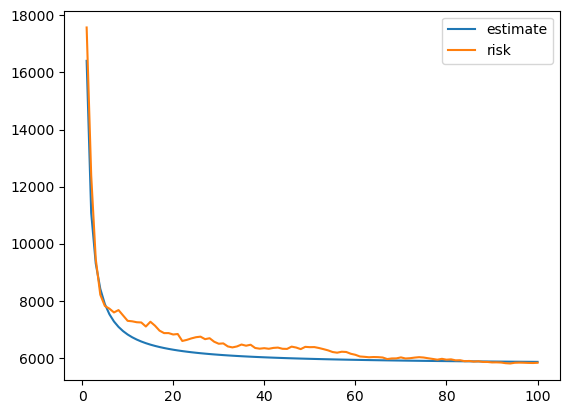

In [8]:
plt.plot(df_est['M'], df_est['estimate'], label='estimate')
plt.plot(df_risk['M'], df_risk['risk'], label='risk')
plt.legend()
plt.show()

Above we show two basic functions and their usage.
One utility of ECV method is that we can also get a risk estimate beyond $M=100$, which gives us a sense how much improvement one can get if we further increase the ensemble size.

In [9]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M_test=1000, M0=30, return_df=True)
df_est

,M,estimate
0,1,16405.277920
1,2,11080.403397
2,3,9305.445223
3,4,8417.966136
4,5,7885.478683
...,...,...
995,996,5766.221393
996,997,5766.210669
997,998,5766.199965
998,999,5766.189284


# ECV estimate for one configuration of ensemble predictors


The function `comp_empirical_ecv` provides an easy way to fit and get risk estimate from ECV.
Similar to the previous section, one need to provide
1. Data: `X_train, y_train`.
2. A regressor class and the parameters to initialize it: `DecisionTreeRegressor, kwargs_regr=kwargs_regr`.
3. The parameters for building the ensemble (with `M` denoting `n_estimators`): `kwargs_ensemble=kwargs_ensemble, M=50`.
4. Extra optional parameters for ECV.

The function returns two objects:
1. An ensemble predictor (an object of `Ensemble`)
2. A np.array or pd.DataFrame object, containing the risk estimates given by ECV.

In [10]:
from sklearn_ensemble_cv import comp_empirical_ecv

kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr, risk_ecv = comp_empirical_ecv(X_train, y_train, DecisionTreeRegressor, kwargs_regr=kwargs_regr,
                   kwargs_ensemble=kwargs_ensemble, M=50)

One can also pass kwargs `X_val=X_test, Y_val=y_test` to get the actual test errors.

# ECV for tuning hyperparameters

For tuning hyperparameters, such as `max_samples` and `max_features` for the ensemble predictors, and `max_depth` and `min_samples_leaf` for all base predictors, we can make two grids of these two types of tuning hyperparameters respectively.

We recommend using `np.array` for each parameter, and make sure to use the correct dtypes that `sklearn` accept.
If one want to set some hyperparameter to a fix value, simply provide it in the grid as either a scalar or a list/array with length one.

In [11]:
from sklearn_ensemble_cv import ECV

# Hyperparameters for the base regressor
grid_regr = {    
    'max_depth':np.array([6,7], dtype=int), 
    }
# Hyperparameters for the ensemble
grid_ensemble = {
    'max_features':np.array([0.9,1.]),
    'max_samples':np.array([0.6,0.7]),
}

res_ecv, info_ecv = ECV(
    X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble, 
    X_test=X_test, Y_test=y_test,
    M=50, M0=25, return_df=True
)

In [12]:
res_ecv

,max_depth,max_features,max_samples,risk_val-1,risk_val-2,risk_val-3,risk_val-4,risk_val-5,risk_val-6,risk_val-7,...,risk_test-41,risk_test-42,risk_test-43,risk_test-44,risk_test-45,risk_test-46,risk_test-47,risk_test-48,risk_test-49,risk_test-50
0,6,0.9,0.6,38719.276463,26980.855921,23068.049073,21111.645649,19937.803595,19155.242225,18596.269818,...,20478.806514,20560.683202,20603.517485,20544.735306,20556.982569,20639.751139,20729.196411,20710.186910,20636.605830,20247.505457
1,6,0.9,0.7,38441.228577,27963.966292,24471.545531,22725.335150,21677.608921,20979.124769,20480.207517,...,20482.475302,20406.422099,20496.363926,20511.436809,20505.397982,20567.662825,20598.579682,20653.733670,20553.326699,20058.996479
2,6,1.0,0.6,17965.733541,12142.966891,10202.044674,9231.583565,8649.306900,8261.122457,7983.847855,...,6692.078440,6685.004535,6674.170083,6696.305082,6675.846579,6665.206489,6660.413744,6505.633163,6603.882829,6579.668967
3,6,1.0,0.7,17557.936724,11657.598555,9690.819165,8707.429470,8117.395653,7724.039775,7443.071290,...,6662.453255,6628.982697,6591.929762,6568.123110,6567.838315,6596.782105,6587.395250,6594.566329,6641.207212,6737.918743
4,7,0.9,0.6,38972.759766,27120.695062,23170.006828,21194.662711,20009.456240,19219.318593,18654.934560,...,20690.585155,20713.929211,20758.422742,20665.143388,20664.740581,20753.428804,20904.148484,20868.391159,20801.193261,20353.214868
5,7,0.9,0.7,37601.467738,27210.298575,23746.575520,22014.713993,20975.597077,20282.852466,19788.034887,...,20399.547775,20282.063657,20349.701409,20379.246186,20377.533024,20414.144477,20467.260361,20523.605520,20435.533113,19940.844091
6,7,1.0,0.6,17784.245784,12027.408728,10108.463043,9148.990200,8573.306495,8189.517357,7915.382260,...,6646.959307,6623.950713,6578.626415,6587.440405,6554.425182,6540.101582,6496.397807,6351.521034,6456.572606,6440.521630
7,7,1.0,0.7,17630.276067,11746.899264,9785.773663,8805.210862,8216.873182,7824.648062,7544.487262,...,6326.271576,6311.330972,6281.323866,6245.940912,6255.214900,6287.195419,6279.677258,6286.804669,6338.697898,6437.921683


In [13]:
info_ecv

{'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 50,
  'max_features': 1.0,
  'max_samples': 0.7},
 'best_n_estimators': 50,
 'best_params_index': 3,
 'best_score': 5993.273911602926,
 'delta': 0.0,
 'M_max': inf,
 'best_n_estimators_extrapolate': inf,
 'best_score_extrapolate': 5757.260384810881}

In [14]:
res_ecv.iloc[info_ecv['best_params_index']]['risk_test-{}'.format(info_ecv['best_n_estimators'])]

6737.918743118372

# SplitCV

In [15]:
from sklearn_ensemble_cv import splitCV
res_splitcv, info_splitcv = splitCV(
        X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble,
        M=50, return_df=True, X_test=X_test, Y_test=y_test,
        random_state=0, test_size=0.25,
        )

In [16]:
res_splitcv

,max_depth,max_features,max_samples,risk_val-1,risk_val-2,risk_val-3,risk_val-4,risk_val-5,risk_val-6,risk_val-7,...,risk_test-41,risk_test-42,risk_test-43,risk_test-44,risk_test-45,risk_test-46,risk_test-47,risk_test-48,risk_test-49,risk_test-50
0,6,0.9,0.6,43268.693998,25138.235452,22172.793254,22001.170898,19376.747050,18964.794123,18756.077617,...,20649.119520,20653.357327,20750.116148,20643.829906,20657.561442,20705.868702,20709.297360,20685.179030,20588.081774,20222.527614
1,6,0.9,0.7,44572.475988,26865.164145,24094.586396,21714.348293,21192.476095,21032.616447,20409.143721,...,20654.816735,20574.149959,20681.902795,20591.935236,20620.266374,20642.217930,20656.907616,20706.020148,20611.209424,20165.480079
2,6,1.0,0.6,8907.975455,11453.334103,8937.190917,6102.385957,5523.382088,5003.415713,6336.135272,...,6990.767809,7014.337364,6923.363434,6825.978225,6833.163458,6858.951817,6853.260853,6850.184380,6900.446386,6855.657039
3,6,1.0,0.7,14016.517314,11587.739015,8570.424168,5195.978266,4901.313771,5251.326586,5888.617100,...,6817.993395,6771.664359,6705.911961,6769.157887,6714.251873,6658.537339,6687.228030,6735.260441,6731.724498,6714.928789
4,7,0.9,0.6,43054.292591,24346.807034,22673.341101,23062.069854,21151.975201,20685.184989,20107.752811,...,20846.901699,20838.105183,20936.594486,20830.380843,20852.573232,20900.286110,20855.258771,20834.364946,20722.500060,20340.060432
5,7,0.9,0.7,41216.634824,26150.864834,24596.504026,22369.060216,22027.141362,22486.188325,21763.492683,...,20363.557623,20268.948953,20401.977669,20374.091915,20393.513917,20393.582096,20425.415967,20487.966200,20321.544944,19856.599598
6,7,1.0,0.6,11614.818029,11946.624793,8441.150300,6373.895736,5564.038803,4655.133977,5649.700787,...,6524.352524,6558.672458,6447.591332,6363.100942,6408.156272,6419.810566,6381.529363,6362.235719,6415.180045,6375.920707
7,7,1.0,0.7,12806.975092,13589.653797,9869.813929,5921.877637,5723.129221,5645.746790,6044.983200,...,6560.512754,6531.449914,6449.972962,6497.462420,6446.857991,6404.155455,6431.866286,6481.340619,6474.400283,6464.822237


In [17]:
info_splitcv

{'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 50,
  'max_features': 1.0,
  'max_samples': 0.7},
 'best_n_estimators': 44,
 'best_params_index': 3,
 'best_score': 3891.5103549310643,
 'split_params': {'index_train': array([ 61,  92, 112,   2, 141,  43,  10,  60, 116, 144, 119, 108,  69,
         135,  56,  80, 123, 133, 106, 146,  50, 147,  85,  30, 101,  94,
          64,  89,  91, 125,  48,  13, 111,  95,  20,  15,  52,   3, 149,
          98,   6,  68, 109,  96,  12, 102, 120, 104, 128,  46,  11, 110,
         124,  41, 148,   1, 113, 139,  42,   4, 129,  17,  38,   5,  53,
         143, 105,   0,  34,  28,  55,  75,  35,  23,  74,  31, 118,  57,
         131,  65,  32, 138,  14, 122,  19,  29, 130,  49, 136,  99,  82,
          79, 115, 145,  72,  77,  25,  81, 140, 142,  39,  58,  88,  70,
          87,  36,  21,   9, 103,  67, 117,  47]),
  'index_val': array([114,  62,  33, 107,   7, 100,  40,  86,  76,  71, 134,  51,  73,
 

In [18]:
res_splitcv.iloc[info_ecv['best_params_index']]['risk_test-{}'.format(info_splitcv['best_n_estimators'])]

6769.157886606206

# KFoldCV

In [19]:
from sklearn_ensemble_cv import KFoldCV
res_kfoldcv, info_kfoldcv = KFoldCV(
        X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble,
        M=50, return_df=True, X_test=X_test, Y_test=y_test,
        shuffle=True, random_state=0, n_splits=5,
        )

In [20]:
res_kfoldcv

,max_depth,max_features,max_samples,risk_val-1,risk_val-2,risk_val-3,risk_val-4,risk_val-5,risk_val-6,risk_val-7,...,risk_test-41,risk_test-42,risk_test-43,risk_test-44,risk_test-45,risk_test-46,risk_test-47,risk_test-48,risk_test-49,risk_test-50
0,6,0.9,0.6,30862.708307,24211.930833,24071.791540,23045.439788,20999.464938,21580.755588,21419.112172,...,20981.803086,20979.912377,21041.268376,20980.181373,20944.428010,20982.885666,21032.256598,21035.693431,21005.923321,20670.509031
1,6,0.9,0.7,29460.498487,23127.857088,24061.913031,22442.908340,21485.073489,21554.559670,20978.851510,...,21132.037837,21152.755679,21273.693174,21230.185238,21210.599396,21255.000267,21277.932324,21276.852928,21215.697211,20848.211156
2,6,1.0,0.6,19242.122978,10474.306371,9942.775721,9673.231363,8997.797120,8858.528289,8368.896593,...,7501.566336,7457.080827,7434.742094,7393.211947,7416.241969,7396.443236,7362.695345,7365.895256,7353.914741,7317.460971
3,6,1.0,0.7,14118.263167,11542.092399,10064.603593,8576.781706,8336.511529,7935.917966,7488.481761,...,6918.687432,6904.215191,6885.969658,6859.236782,6900.357703,6812.558479,6803.588533,6830.977088,6832.917386,6841.045502
4,7,0.9,0.6,33918.221796,25593.318890,24953.223548,23779.300729,22136.816039,22506.528827,21990.006467,...,20922.972962,20921.442147,21000.995223,20933.979053,20910.521771,20921.144464,20963.601955,20970.976645,20927.939653,20586.406099
5,7,0.9,0.7,30064.903322,23701.807965,24467.648443,23235.533768,23152.746306,22534.855139,21996.164170,...,20836.159947,20864.338415,20982.482474,20940.338128,20907.362689,20956.306403,20984.794105,21001.549733,20948.675074,20602.848099
6,7,1.0,0.6,19042.773541,10832.833475,9809.694529,9350.842310,8830.871328,8661.829882,8239.795835,...,7507.190899,7459.675714,7435.780076,7377.001541,7397.693849,7373.527771,7336.941412,7340.612578,7327.620029,7287.608466
7,7,1.0,0.7,14434.838074,12125.773605,10680.230778,9082.752138,8627.047156,8437.308850,7784.171500,...,7030.084270,7016.246798,7003.336368,6976.364518,7018.287142,6942.707738,6921.869680,6943.659339,6953.803015,6959.454304


In [21]:
info_kfoldcv

{'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 50,
  'max_features': 1.0,
  'max_samples': 0.7},
 'best_n_estimators': 46,
 'best_params_index': 3,
 'best_score': 6369.951706825984,
 'val_score': array([[[24883.12392799, 45646.83709821, 29653.69354136, 27289.89561493,
          26839.99135084],
         [24612.76128912, 32170.87395597, 24590.13967848, 16404.95181345,
          23280.92743007],
         [20310.99880646, 34677.25111337, 25632.04278923, 16117.96261324,
          23620.70237681],
         ...,
         [17859.47592126, 19683.15498303, 18405.06394436, 19282.68593505,
          24630.41414141],
         [17929.19989849, 19527.99638498, 18366.53275684, 19298.6827757 ,
          24625.47619192],
         [17422.8397265 , 18922.30728278, 18129.67830356, 19384.85809394,
          24250.18805986]],
 
        [[25509.90414079, 40361.46677818, 27552.65959187, 35184.2483388 ,
          18694.21358386],
         [21537.69043446, 

In [22]:
res_kfoldcv.iloc[info_ecv['best_params_index']]['risk_test-{}'.format(info_kfoldcv['best_n_estimators'])]

6812.558478772342

# GCV and CGCV


## GCV estimates

Generalized cross-validation (GCV) is a method for estimating the prediction error of an estimator. It is commonly used in the context of linear smoother, including ridge regression, lasso, and elastic net. 
It is a form of cross-validation without data splitting, where the estimated risk is the training error divided by the effective number of degrees of freedom of the estimator.

There are two variants of the naive GCV for ensemble learning:
- 'full': using all observations to estimate the risk $$\tilde{R}_M^{gcv} = \frac{\|{{y}}-{{X}}\tilde{\beta}_{M}\|_2^2 / n }{(1 - \tilde{df}_M / n )^2},$$
which is consistent when $k=n$ or $M=\infty$.
- 'union': using the union of training observations to estimate the risk $$\tilde{R}_M^{gcv} = \frac{\|{ L}_{I_{1:M}} ({{y}}-{{X}}\tilde{\beta}_{M})\|_2^2 / |I_{1:M}| }{(1 - \tilde{df}_M / |I_{1:M}| )^2},$$
which is consistent when $k=n$ or $M\in\{1,\infty\}$.

In [23]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn_ensemble_cv import generate_data

reset_random_seeds(0)
n_samples, n_features = 1000, 500
Sigma, beta0, X_train, y_train, X_test, y_test, _, _ = generate_data(
    n_samples, n_features, coef='random', func='quad', sigma_quad=.1,
    rho_ar1=0., sigma=.1, df=np.inf, n_test=1000, 
)

kwargs_regr = {'alpha': 0.05*X_train.shape[0], 'fit_intercept':False}
kwargs_ensemble = {'max_samples': 0.8, 'bootstrap':False}
regr = Ensemble(estimator=Ridge(**kwargs_regr), n_estimators=100, **kwargs_ensemble)
regr = regr.fit(X_train, y_train)

In [24]:
df_gcv = regr.compute_gcv_estimate(X_train, y_train, M0=25, type='union', return_df=True)

In [25]:
df_risk = regr.compute_risk(X_test, y_test, return_df=True)

# CGCV estimates

The correct GCV estimators are shown to be consistent for arbitrary ensemble sizes:
$$\tilde{R}^{cgcv,\#}_{M}
        = \underbrace{\frac{\|{{y}}-{{X}}\tilde{\beta}_{M}\|_2^2 / n }{(1 - \tilde{df}_M / n )^2} }_{\tilde{R}_M^{gcv}}
        -  \underbrace{\frac{1}{M} \Biggl\{ \frac{(\tilde{df}_M/n)^2}{(1-\tilde{df}_M/n)^2} \frac{1}{M}\sum_{m \in [M]} \bigg(\frac{n}{|I_m|}-1\bigg) \hat{R}_{m, m}^{\#} \Biggr\}}_{\mathrm{correction}}.$$

There are two options of the risk component estimators:
- $\#=$'full': using full observations to estimate $R_{m,m}$.
- $\#=$'ovlp': using overlapping observations to estimate $R_{m,m}$.

Intuitively, the former should be more robust as more observations are used.

In [26]:
df_cgcv = regr.compute_cgcv_estimate(X_train, y_train, M0 = 25, type='full', return_df=True)

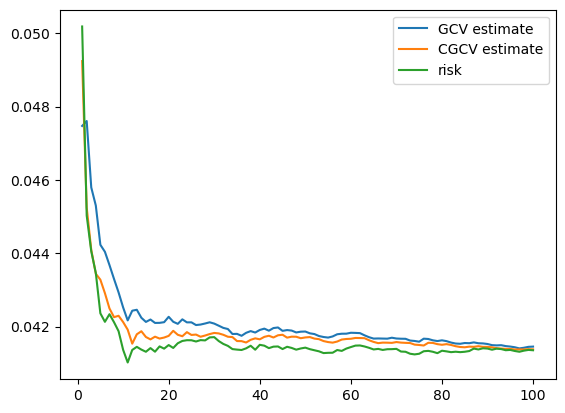

In [27]:
plt.plot(df_gcv['M'], df_gcv['estimate'], label='GCV estimate')
plt.plot(df_cgcv['M'], df_cgcv['estimate'], label='CGCV estimate')
plt.plot(df_risk['M'], df_risk['risk'], label='risk')
plt.legend()
plt.show()

## GCV and CGCV for tuning

Below we apply CGCV for tuning ensemble parameters for ridge.
The function `GCV` also supports naive GCV estimates (when `corrected=False`), though they are inconsistent to prediction risk and are only included for completeness.
Therefore, we do not recommend to use naive GCV for tuning.

Both GCV and CGCV are proposed for subagging (when `bootstrap=False` in `kwargs_regr`), however, they also provide reasonable estimates for bagging numerically, as we illustrate below.

In [28]:
from sklearn_ensemble_cv import GCV

grid_regr = {'alpha': np.array([0.01,0.05])*X_train.shape[0]}
grid_ensemble = {'max_samples': [0.6,0.8]}

res_cgcv, info_cgcv = GCV(
        X_train, y_train, Ridge, grid_regr, grid_ensemble,
        M=100, M0=25, corrected=True, type='full', return_df=True, X_test=X_test, Y_test=y_test,
        )

In [29]:
res_cgcv

,alpha,max_samples,risk_val-1,risk_val-2,risk_val-3,risk_val-4,risk_val-5,risk_val-6,risk_val-7,risk_val-8,...,risk_test-91,risk_test-92,risk_test-93,risk_test-94,risk_test-95,risk_test-96,risk_test-97,risk_test-98,risk_test-99,risk_test-100
0,10.0,0.6,0.206207,0.132746,0.108259,0.096016,0.088670,0.083772,0.080274,0.077651,...,0.067162,0.067099,0.067129,0.067290,0.067470,0.067083,0.067079,0.066879,0.066811,0.067019
1,10.0,0.8,0.100916,0.064620,0.052521,0.046471,0.042842,0.040422,0.038694,0.037397,...,0.030136,0.030101,0.030069,0.030088,0.030075,0.029989,0.029957,0.029872,0.029873,0.029920
2,50.0,0.6,0.242640,0.182598,0.162584,0.152577,0.146572,0.142569,0.139710,0.137566,...,0.134814,0.134754,0.134813,0.134971,0.135147,0.134663,0.134617,0.134338,0.134367,0.134616
3,50.0,0.8,0.146417,0.108799,0.096260,0.089990,0.086228,0.083721,0.081929,0.080586,...,0.078384,0.078293,0.078321,0.078293,0.078385,0.078181,0.078117,0.077914,0.077971,0.078107


In [30]:
info_cgcv

{'best_params_regr': {'alpha': 10.0},
 'best_params_ensemble': {'random_state': 0,
  'n_estimators': 100,
  'max_samples': 0.8},
 'best_n_estimators': 100,
 'best_params_index': 1,
 'best_score': 0.029049100609569466}

In [31]:
res_cgcv.iloc[info_cgcv['best_params_index']]['risk_test-{}'.format(info_cgcv['best_n_estimators'])]

0.02991999558706754